### Washington data

In [2]:
pwd()

'c:\\Users\\max-admin\\Desktop\\Masterstudium\\Masterarbeit\\Master_Thesis\\Data'

In [2]:
import pandas as pd


In [8]:
import os
import pandas as pd

def read_and_merge_multiyear_data(years, base_path='DC_data'):
    """
    Reads in, aggregates, and merges data for each month of specified years into one DataFrame,
    excluding January 2015 and adjusting for file format and delimiter changes.
    The ORIGINDATETIME_TR column is converted to a pandas datetime object, normalized to date.

    Parameters:
    years (list of str): The years for which to read the data.
    base_path (str): The base path where the data files are stored.

    Returns:
    pandas.DataFrame: A DataFrame containing the aggregated and merged data for all specified years.
    """
    aggregated_dfs = []

    # Iterate over each year
    for year in years:
        # Iterate over all months
        for month in range(1, 13):
            # Exclude January 2015
            if year == '2015' and month == 1:
                continue

            # Determine file extension and delimiter based on year and month
            if int(year) >= 2019 and month >= 7:
                file_extension = 'csv'
                delimiter = ','
            else:
                file_extension = 'txt'
                delimiter = '|'

            # Construct the file path
            file_path = os.path.join(base_path, year, f'taxi_{year}_{month:02d}.{file_extension}')

            # Check if the file exists
            if os.path.exists(file_path):
                # Read the file with appropriate delimiter
                df = pd.read_csv(file_path, delimiter=delimiter)

                # Convert ORIGINDATETIME_TR to datetime and normalize to date
                df['ORIGINDATETIME_TR'] = pd.to_datetime(df['ORIGINDATETIME_TR']).dt.normalize()

                # Filter out rows where 'AIRPORT' is 'Y'
                df = df[df['AIRPORT'] != 'Y']

                # Aggregate data
                aggregated_df = df.groupby(['ORIGINZIP', 'ORIGINDATETIME_TR']).agg(
                    trip_count=('ORIGINZIP', 'count'),
                    average_mileage=('MILEAGE', 'mean'),
                    average_totalamount=('TOTALAMOUNT', 'mean')
                ).reset_index()

                # Append aggregated data
                aggregated_dfs.append(aggregated_df)

    # Concatenate all aggregated dataframes
    merged_aggregated_df = pd.concat(aggregated_dfs, ignore_index=True)

    return merged_aggregated_df

# Example usage
years = ['2015','2016','2017','2018','2019']  # Specify the years you want to include
aggregated_data = read_and_merge_multiyear_data(years)


C:\Users\max-admin\AppData\Local\Temp\ipykernel_21492\186558185.py:41: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter=delimiter)
C:\Users\max-admin\AppData\Local\Temp\ipykernel_21492\186558185.py:41: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter=delimiter)
C:\Users\max-admin\AppData\Local\Temp\ipykernel_21492\186558185.py:41: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter=delimiter)
C:\Users\max-admin\AppData\Local\Temp\ipykernel_21492\186558185.py:41: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter=delimiter)
C:\Users\max-admin\AppData\Local\Temp\ipykernel_21492\186558185.py:41: DtypeWarning: Columns (15) have mi

In [15]:
aggregated_data.to_csv("DC_data/merged_grouped_DC.csv")

In [74]:
import pandas as pd
import numpy as np
import datetime as dt
import holidays
from matplotlib.cbook import boxplot_stats 

def fahrenheit_to_celsius(f):
        return (f - 32) * 5/9


def process_DC_zipcode():
    """
    Merges aggregated chicago cab date with weather data and creates a csv file for
    further analysis
    
    input: PU_or_DO: string, either "PU" or "DO"    
    
    """


    trips = pd.read_csv("DC_data/merged_grouped_DC.csv")
    
    


    climate = pd.read_csv("DC_data/weather_DC.csv")
    climate.drop(columns=["NAME" , "STATION"], inplace = True)

    # sort by date
    trips = trips.sort_values(by=['ORIGINDATETIME_TR']).reset_index(drop=True)
    # drop Nas 
    trips = trips.dropna()
    

    # merge trips and climate data on date
    trips = pd.merge(trips, climate, how='left', left_on='ORIGINDATETIME_TR', right_on='DATE')

    us_holidays = holidays.US()

    # Create a new column indicating whether each date is a holiday or not
    trips['holiday'] = trips['ORIGINDATETIME_TR'].apply(lambda x: 1 if x in us_holidays else 0)


    # Apply the conversion function to the Fahrenheit column
    trips['TMAX'] = trips['TMAX'].apply(fahrenheit_to_celsius)

    # add a weekday index to the dataframe starting with Mondays = 0 tuesdays = 1 etc.
    trips['Weekday_index'] = pd.to_datetime(trips['ORIGINDATETIME_TR']).dt.dayofweek

    taxi_data = trips

    # rename columns
    taxi_data.rename(columns={'ORIGINDATETIME_TR':'date_pickup' , 'ORIGINZIP' : 'PULocationID' , 'trip_count' : 'trip_number' , 'TMAX' : 'tmax_obs'}, inplace=True)
    

    # add month and year factors
    taxi_data['Year_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.year)[0] + 1
    taxi_data['Month_fact'] = pd.factorize(pd.to_datetime(taxi_data['date_pickup']).dt.month)[0] + 1
    # log the dependent variable
    taxi_data['log_total'] = np.log(taxi_data['trip_number'] + 1)
    # remove NAs
    taxi_data = taxi_data.dropna(subset=['tmax_obs'])

    # add chebyshev_polynomials
    num_days = len(taxi_data["date_pickup"].unique())
    taxi_data["cheby_0"] = 1
    taxi_data["cheby_1"] = taxi_data['date_pickup'].rank(method='dense').astype(int)/num_days

    # recursively defining other chebyshev polynomials for each day until 5th order
    for i in range(2, 6):
        taxi_data[f"cheby_{i}"] = (2  * taxi_data["cheby_1"] * taxi_data[f"cheby_{i-1}"]) - taxi_data[f"cheby_{i-2}"]

    # outlier filtering
    out_weekdays = pd.DataFrame()
    filtered_weekdays = pd.DataFrame()
    counter = 1
    for z in taxi_data[f'PULocationID'].unique():
        zcta_data = taxi_data[taxi_data[f'PULocationID'] == z]
        for w in taxi_data['Weekday_index'].unique():
            zcta_weekday = zcta_data[zcta_data['Weekday_index'] == w]
            out = np.ravel(boxplot_stats(zcta_weekday['log_total'])[0]['fliers'])
            out_ids = np.where(np.isin(zcta_weekday['log_total'], out))[0]
            out_df = zcta_weekday.iloc[out_ids]
            zcta_filtered = zcta_weekday = zcta_weekday.drop(out_df.index)
            if counter == 1:
                out_weekdays = out_df
                filtered_weekdays = zcta_filtered
            else:
                out_weekdays = pd.concat([out_weekdays, out_df])
                filtered_weekdays = pd.concat([filtered_weekdays, zcta_filtered])
            counter += 1
    
     # compute count of outliers per day
    date_count = out_weekdays.groupby('date_pickup').size().reset_index(name='n')


    # get all days that are outliers in at least 35% of the neighborhoods -- ???
    date_system_outliers = date_count[date_count['n'] >= 43]['date_pickup']
    out_weekdays_system = taxi_data[~taxi_data['date_pickup'].isin(date_system_outliers)]

    taxi_data = out_weekdays_system


    # add temperature bins
    sequence_bins = np.arange(np.floor(taxi_data['tmax_obs'].min()), np.ceil(taxi_data['tmax_obs'].max()) + 1, 3)
    temp_bins = pd.cut(taxi_data['tmax_obs'], bins=sequence_bins, include_lowest=True, ordered = True)
    taxi_data['temp_bins'] = temp_bins

    # restrict taxi_data to temperature range -13 to 35
    taxi_data_cut = taxi_data[(taxi_data['tmax_obs'] >= -13) & (taxi_data['tmax_obs'] <= 39)]

    taxi_data_cut.to_csv(f"DC_data/DC_regression_zipcodes.csv", index=False)


In [3]:
data = pd.read_csv("DC_data/merged_grouped_DC.csv")

In [5]:
data.ORIGINZIP.unique()

array(['0', '2011', '6704', ..., '20531', '61883', '88888'], dtype=object)

In [75]:
process_DC_zipcode()

In [1]:
DC_PU = pd.read_csv("DC_data/DC_regression_zipcodes.csv")

NameError: name 'pd' is not defined

Index(['(-7.001, -4.0]', '(-4.0, -1.0]', '(-1.0, 2.0]', '(2.0, 5.0]',
       '(5.0, 8.0]', '(8.0, 11.0]', '(11.0, 14.0]', '(14.0, 17.0]',
       '(17.0, 20.0]', '(20.0, 23.0]', '(23.0, 26.0]', '(26.0, 29.0]',
       '(29.0, 32.0]', '(32.0, 35.0]', '(35.0, 38.0]'],
      dtype='object')


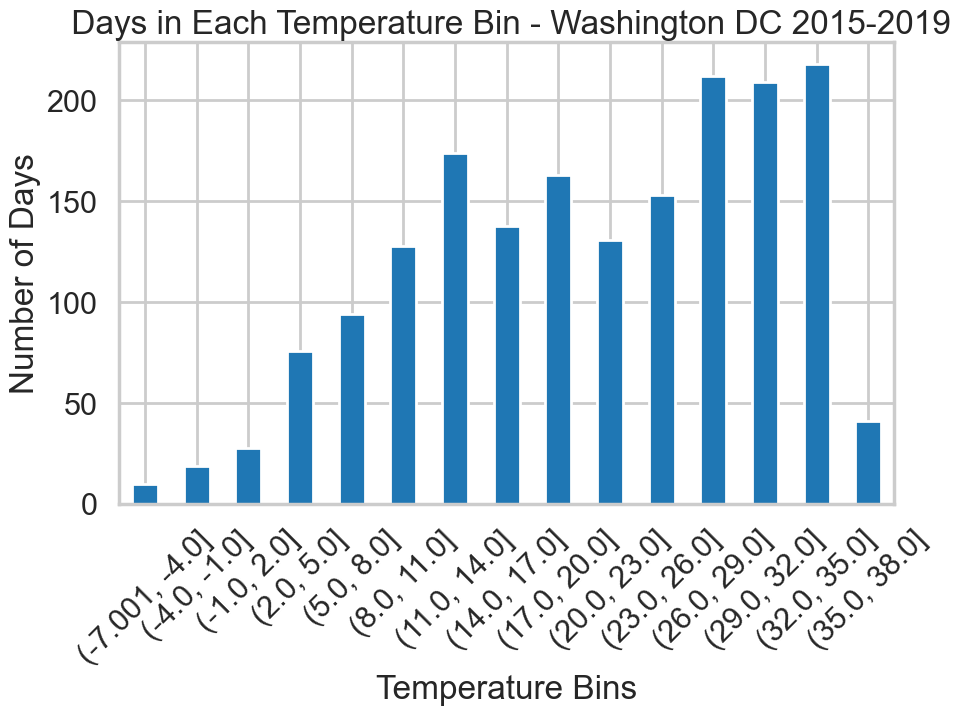

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'DC_PU' is your DataFrame

# Explicitly define the correct order of your temperature bins
ordered_temp_bins = [
    '(-10.0, -7.0)','(-7.0, -4.0]', '(-4.0, -1.0]', '(-1.0, 2.0]', '(2.0, 5.0]', '(5.0, 8.0]',
    '(8.0, 11.0]', '(11.0, 14.0]', '(14.0, 17.0]', '(17.0, 20.0]', '(20.0, 23.0]',
    '(23.0, 26.0]', '(26.0, 29.0]', '(29.0, 32.0]', '(32.0, 35.0]', '(35.0, 38.0]'
]

# Convert the 'temp_bins' column to a categorical type with the specified order
DC_PU['temp_bins'] = pd.Categorical(DC_PU['temp_bins'], categories=ordered_temp_bins, ordered=True)

# Verify the order of categories
print(DC_PU['temp_bins'].cat.categories)

# Create a new DataFrame with unique days
unique_days = DC_PU[['date_pickup', 'temp_bins']].drop_duplicates()

# Count the occurrences of each bin, respecting the categorical order
temp_bin_counts = unique_days['temp_bins'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10,6))
# Ensure the plot respects the categorical order
temp_bin_counts.reindex(ordered_temp_bins).plot(kind='bar')
plt.title(' Days in Each Temperature Bin - Washington DC 2015-2019')
plt.xlabel('Temperature Bins')
plt.ylabel('Number of Days')
plt.xticks(rotation=45)
plt.show()


In [71]:
from linearmodels.panel import PanelOLS


DC_PU['temp_bins'] = pd.Categorical(DC_PU['temp_bins'], ordered=False).astype(str)
DC_PU['temp_bins'] = DC_PU['temp_bins'].str.replace('\(', '[', regex=True)

# add cheby polynomials for chicago

num_days = len(DC_PU["date_pickup"].unique())

DC_PU["cheby_0"] = 1
DC_PU['cheby_1'] = DC_PU['date_pickup'].rank(method='dense').astype(int) / num_days

for i in range(2, 6):
    DC_PU[f"cheby_{i}"] = (2 * DC_PU["cheby_1"] * DC_PU[f"cheby_{i-1}"]) - DC_PU[f"cheby_{i-2}"]


panel_data = DC_PU.set_index(['PULocationID', 'Year_fact'])


model_formula = 'log_total ~ 1 +  C(temp_bins, Treatment(reference = "[14.0, 17.0]")) + PRCP + AWND + Weekday_index + holiday + + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + EntityEffects + TimeEffects'

model = PanelOLS.from_formula(model_formula, data=panel_data)

# Fit the model
results_DC = model.fit(cov_type='clustered', cluster_entity=True)

# Print the regression results in latex format
print(results_DC)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_total   R-squared:                        0.0256
Estimator:                   PanelOLS   R-squared (Between):             -1.4421
No. Observations:              285310   R-squared (Within):              -0.0108
Date:                Mon, Dec 04 2023   R-squared (Overall):             -0.0318
Time:                        18:44:14   Log-likelihood                -3.077e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      309.69
Entities:                        2190   P-value                           0.0000
Avg Obs:                       130.28   Distribution:               F(24,283092)
Min Obs:                       1.0000                                           
Max Obs:                       1091.0   F-statistic (robust):             32.658
                            

In [31]:
df

,Coefficient,Lower CI,Upper CI,Temperature
1,-0.090820,-0.122555,-0.059085,"[-1.0, 2.0]"
2,-0.248476,-0.285871,-0.211080,"[-4.0, -1.0]"
3,-0.241508,-0.283450,-0.199566,"[-7.001, -4.0]"
4,-0.014792,-0.024527,-0.005056,"[11.0, 14.0]"
5,0.067732,0.057525,0.077939,"[17.0, 20.0]"
6,-0.046546,-0.067255,-0.025837,"[2.0, 5.0]"
7,0.028665,0.013194,0.044136,"[20.0, 23.0]"
8,0.064518,0.049643,0.079394,"[23.0, 26.0]"
9,0.075795,0.061363,0.090227,"[26.0, 29.0]"
10,0.081769,0.062704,0.100834,"[29.0, 32.0]"


In [32]:
def plot_regression(model_fit,dataset,fixed_effect_level,outcome):
    """
    Plots coefficients for log_trip number and their condifence intervals against each temperature bin.

    Inputs:
        model_fit: the fitted regression model
        dataset(str): Green,Yellow or FHV
        fixed_effect_level(str): Pickup or Dropoff Location
        outcome(str): Trip number or Trip distance
    
    
    Returns:
       Plot
    
    """
    results = model_fit

    # Prepare summary for plotting

    coefficients = results.params
    conf_int = results.conf_int()

    # Combine coefficients and confidence intervals into a single DataFrame
    df = pd.DataFrame(pd.concat([coefficients, conf_int], axis=1))
    df.columns = ['Coefficient', 'Lower CI', 'Upper CI']

    # convert the index into a regular column
    df.reset_index(inplace=True)

    # only keep the rows where index starts with C(temp_bins)
    df = df[df['index'].str.startswith('C(temp_bins')]

    # add temperature variable to the dataframe which drops everything from the string until the first "T."
    # remove temp bin called nan
    
    df['Temperature'] = df['index'].str.split(r'\[T\.').str[1].str[:-1]
    df = df[df['Temperature'] != 'nan']
    df.drop(columns=['index'], inplace=True)

    # Convert Temperature intervals into numerical values
    df['Temperature'] = df['Temperature'].str.strip('[]').str.split(',').apply(lambda x: (float(x[0]) + float(x[1])) / 2)
    # order the dataframe by temperature
    df = df.sort_values(by=['Temperature'])

    # convert the coeffients into percentages and adapt CI accordingly
    df['Coefficient'] = df['Coefficient'] * 100
    df['Lower CI'] = df['Lower CI'] * 100
    df['Upper CI'] = df['Upper CI'] * 100

    # Extract Temperature and Coefficient values
    temperature = df['Temperature']
    coefficient = df['Coefficient']

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature, coefficient, color='blue', label='Data')
    plt.xlabel('Temperature')
    plt.ylabel(f'{outcome} response in %')
    plt.title(f'Mobility response by temperature bin- {dataset}')

    # Add confidence intervals if needed
    lower_ci = df['Lower CI']
    upper_ci = df['Upper CI']
    plt.errorbar(temperature, coefficient, yerr=[coefficient - lower_ci, upper_ci - coefficient], fmt='o', color='red' , capsize= 3,  barsabove = True , label='Confidence Interval')

    # Fit a polynomial
    degree = 2
    coefficients_poly = np.polyfit(temperature, coefficient, degree)
    y_poly = np.polyval(coefficients_poly, temperature)

    # Plot the polynomial curve
    plt.plot(temperature, y_poly, label=f'Polynomial Fit (Degree {degree})', color='green')

    # add a dotted line at 0 percent
    plt.axhline(y=0, color='blue', linestyle='--')

    # Add a legend
    plt.legend()
    plt.text(0.5, -0.15, f'Red dots show the coefficients for the temperature bins (each 3°C ) on log({outcome}) as the dependent variable in a panel regression which \n included month and {fixed_effect_level} fixed effects. Standard Errors are clustered at the borough level. Percentage change in trips is relative to the 16-19°C bin. \n Trips which started or ended at the airport are excluded from the analysis. The specification includes Chebyshev polynomials up until order 5' , ha='center', va='center', transform=plt.gca().transAxes)
    # Show the plot
    plt.show()


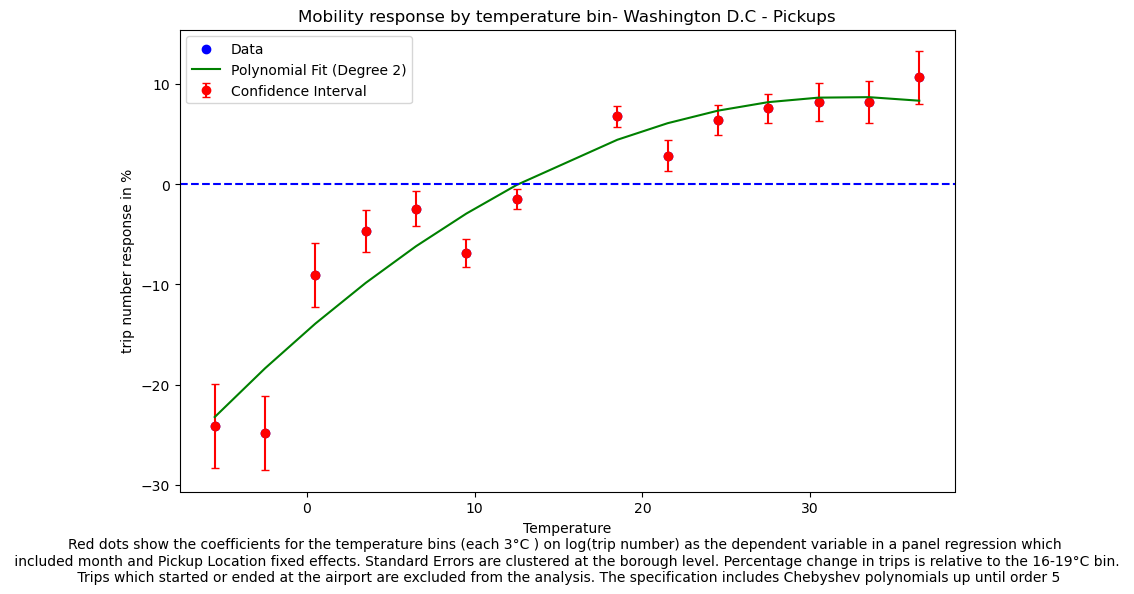

In [33]:
import matplotlib.pyplot as plt
plot_regression(results_DC,'Washington D.C - Pickups','Pickup Location','trip number')